In [1]:
import torch
import pandas as pd
import numpy as np
import transformers
import torchvision
from torchvision import models, transforms
from PIL import Image
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup
import random
import time
import os
import re
import math

In [2]:
from train_val import *
from data_loader import *


df_train = pd.read_csv("../../AAAI_dataset/gossip_train.csv")
df_test = pd.read_csv("../../AAAI_dataset/gossip_test.csv")

if torch.cuda.is_available():       
    device = torch.device("cuda:1")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(1))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
# define a callable image_transform with Compose
image_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size=(224, 224)),
        torchvision.transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

There are 2 GPU(s) available.
Device name: GeForce GTX 1080 Ti


In [3]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Specify `MAX_LEN`
MAX_LEN = 500
root_dir = "../../AAAI_dataset/Images/"

# Run function `preprocessing_for_bert` on the dataset
transformed_dataset_train = FakeNewsDataset(df_train, root_dir+"gossip_train/", image_transform, tokenizer, MAX_LEN)

transformed_dataset_val = FakeNewsDataset(df_test, root_dir+"gossip_test/", image_transform, tokenizer, MAX_LEN)

train_dataloader = DataLoader(transformed_dataset_train, batch_size=8,
                        shuffle=True, num_workers=0)

val_dataloader = DataLoader(transformed_dataset_val, batch_size=8,
                        shuffle=True, num_workers=0)

In [4]:
# # Specify loss function
# loss_fn = nn.CrossEntropyLoss()


# def set_seed(seed_value=42):
#     """Set seed for reproducibility.
#     """
#     random.seed(seed_value)
#     np.random.seed(seed_value)
#     torch.manual_seed(seed_value)
#     torch.cuda.manual_seed_all(seed_value)


In [5]:
!nvidia-smi

Tue Dec  8 17:25:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:0A:00.0 Off |                  N/A |
| 54%   84C    P2   269W / 250W |  12192MiB / 12196MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:41:00.0 Off |                  N/A |
|  0%   

In [6]:
parameter_dict_model={
    'fine_tune_text_module': False,
    'img_enc_fc_dim':512,
    'img_enc_cnn':7,
    'fine_tune_vis_module': False,
    'text_enc_dim':768,
    'img_enc_dim':512, ## nb_channels
    'comb_enc_dim': 1,
    'att_dim':100,
    'text_emb_size':768,
    'text_latent_dim':256,
    'hidden_size':512,
    'vis_emb_size':512,
    'vis_enc_dim':256,
    'fusion_output_size':256,
    'num_classes':2,
    'dropout_p': 0.3
}

parameter_dict_opt={'l_r': 2e-5,
                    'eps': 1e-8
                    }

# EPOCHS=1

# set_seed(42)    # Set seed for reproducibility

In [7]:
from mult_att import *
final_model = LanguageAndVisionConcat(parameter_dict_model)

final_model = final_model.to(device) 

In [8]:
loaded_variables = torch.load("./saved_models/best_model.pt",  map_location=device)
final_model.load_state_dict(loaded_variables['model_state_dict'])

<All keys matched successfully>

In [9]:
!nvidia-smi

Tue Dec  8 17:29:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:0A:00.0 Off |                  N/A |
| 51%   76C    P2   200W / 250W |  12192MiB / 12196MiB |     53%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:41:00.0 Off |                  N/A |
|  0%   

In [10]:
import matplotlib.pyplot as plt
import skimage.transform
import matplotlib.cm as cm

viridis = cm.get_cmap('viridis', 12)

In [11]:
def plot_img_att_map(img, att_mask):
    
    ## resize attention maps to actual image size 
    alpha = skimage.transform.resize(att_mask.to("cpu").numpy(), [224, 224])
    plt.imshow(img.to("cpu").permute(1, 2, 0))

    ## plot attentnion maps 
    plt.imshow(alpha, alpha=0.8)
    plt.set_cmap(cm.Greys_r)
    plt.show()

In [27]:
def plot_text_att(att_text):
    plt.figure(figsize = (20,2))
    max_norm = att_mask_text.max()
    plt.imshow(att_mask_text.cpu().numpy().T,  vmin=0, vmax=max_norm, cmap='jet', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


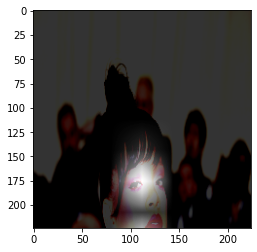

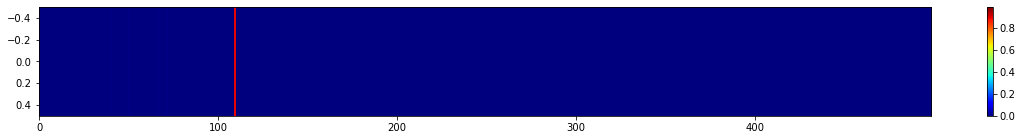

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text Input: with label= tensor(1, device='cuda:1')
[CLS] rihanna at the met gala : see all of her red carpet looks wherever she is going , rihanna always seems to impress with her noteworthy looks . whether she is making a statement leaving a restaurant with wine glass in hand , or showing off her own fen ##ty x pu ##ma designs , she is consistently one to watch both on and off the red carpet . rihanna has blessed us with some insane style moments , the met gala being no exception . her past met gala looks vary from a tailored suit in 2009 , to a revealing stella mccartney white two - piece gown in 2014 . on the 2015 red carpet , rihanna was und ##enia ##bly one of the best dressed in attendance wearing a yellow guo pei gown with an insane ##ly elaborate train and a matching head ##piece that made headlines and may be one of the most memorable met gala looks of all time . in 2017 , she stole the show again in com ##me des ga ##rco ##ns . here is a look back at rihanna at the gala from 

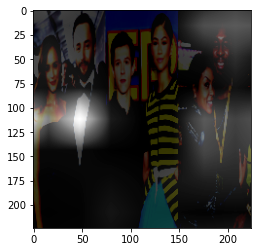

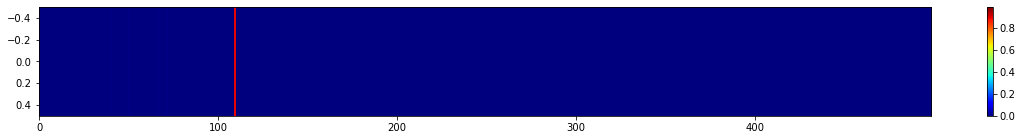

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text Input: with label= tensor(1, device='cuda:1')
[CLS] 31 celebrity couples so secretive you forgot they ’ re dating tasha mcc ##au ##ley and joseph gordon - levi ##tt gordon - levi ##tt married tasha mcc ##au ##ley , who has an mba and a degree in robotics , in 2014 and the couple has two children together . the family has chosen to stay as far away from the lime ##light as possible . " she really doesn ' t want to be a part of it and you can imagine not wanting to have that kind of scrutiny , " gordon - levi ##tt told howard stern of his wife before they got married . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

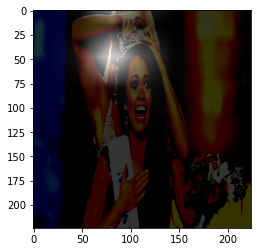

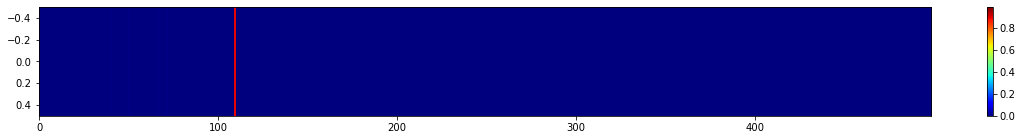

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text Input: with label= tensor(1, device='cuda:1')
[CLS] miss america slams the miss america organization and gretchen carlson cara mu ##nd , whose reign as miss america comes to a close next month , accused the pageant ’ s parent organization of systematically si ##len ##cing her in a letter made public friday . it was the latest set ##back for the organization , which has struggled to rein ##vent itself after a string of scandals . in a miss ##ive that ran over 3 , 000 words long , ms . mu ##nd said that the pageant ’ s leadership had “ reduced me , marginal ##ized me , and essentially erased me in my role as miss america in subtle and not - so - subtle ways on a daily basis . ” she went on to say that members of the organization had prevented her from posting in her official capacity on social media and had criticized her appearance on multiple occasions . she added that she had researched new jersey state laws and that the mist ##rea ##tment amounted to “ workplace bullying . ” she

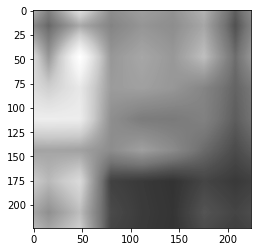

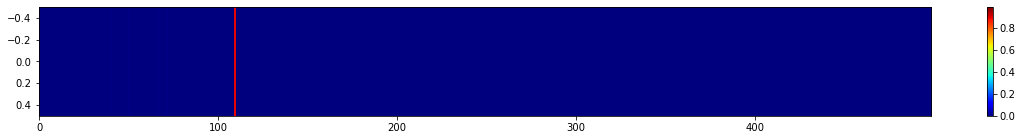

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text Input: with label= tensor(0, device='cuda:1')
[CLS] colin farrell ' s 10 cr ##azi ##est antics no articles found . try our search here : [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

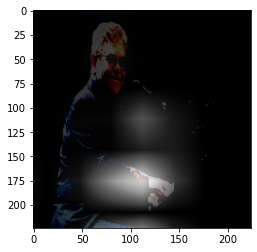

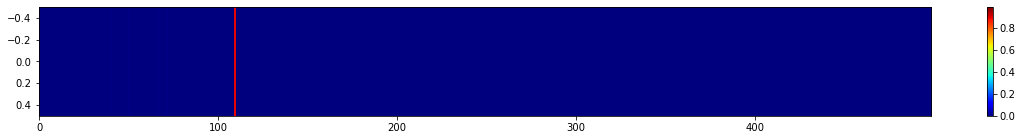

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text Input: with label= tensor(1, device='cuda:1')
[CLS] elton john explains why he stormed off stage during las vegas concert it doesn ’ t have to be a saturday night to put elton john in a fighting mood and he proved that on thursday when he took issue with a “ hands ##y ” fan and stormed off stage mid - concert . sir elton was performing his classic song “ saturday night ’ s alright ” during his las vegas residency , and as per tradition , he invited a group of fans up to the stage to gather around the piano while he played . everyone seemed to be having a good time until an over ##ze ##alo ##us fan reached over to touch the singer as he was singing the 1973 hit . in a video obtained by t ##m ##z , you can see the “ rocket man ” hit ##maker lean over and yell , “ f * * * off ” off - mic . the iconic british singer tries to continue un ##fa ##zed , but as the touching persist ##s , he becomes increasingly agitated , repeatedly screaming “ f * * * off ” at the touch ##y - feel ##y con

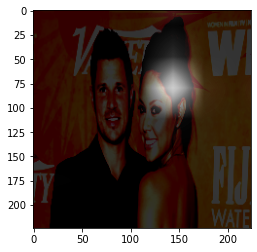

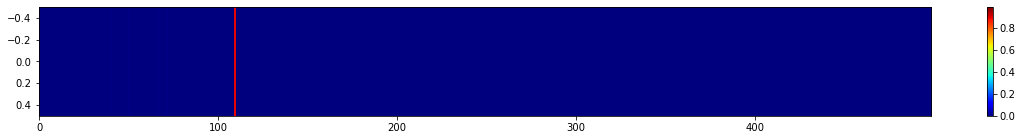

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text Input: with label= tensor(1, device='cuda:1')
[CLS] nick lac ##hey shares sweet ##est sixth anniversary message for ' beautiful ' wife and ' soul mate ' vanessa nick and vanessa lac ##hey are serious marriage goals . the former 98 degrees frontman paid tribute to his " beautiful " wife , vanessa , on saturday as the two celebrated their sixth wedding anniversary . nick posted a gorgeous black - and - white photograph from the couple ' s 2011 tropical wedding , along with a heart ##felt message and the # soul ##mate hash ##tag . related : vanessa lac ##hey lost her wedding ring , so husband nick searched through the trash to find it ! " six years ago today , i took this beautiful woman as my wife and the life we ' ve built together is more incredible than anything i could have ever imagined ! ! " the 43 - year - old singer wrote . " through all of the laughter , tears , triumph ##s , and challenges , you are my un ##con ##ditional rock . i love you and our family more than you will

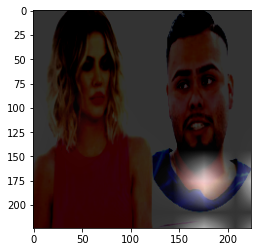

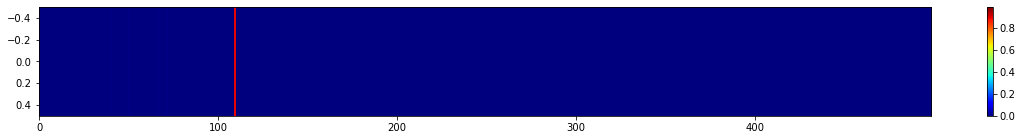

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text Input: with label= tensor(1, device='cuda:1')
[CLS] k ##hl ##oe ka ##rda ##shi ##an fires a contestant from revenge body k ##hl ##oe ka ##rda ##shi ##an may come off as a soft ##ie on keeping up with the ka ##rda ##shi ##ans . but on her spin ##off show revenge body with k ##hl ##oe ka ##rda ##shi ##an , she ' s much tough ##er , as was witnesses on monday when she asked one contestant to leave . the 33 - year - old pregnant star told joel to pack up his things after he was caught in lies . on twitter the next day k ##hl ##oe said : ' so di ##sr ##es ##pe ##ct ##ful ! ! joel totally played us . . . and we have no time for fake ##rs ! ! ' please go : k ##hl ##oe ka ##rda ##shi ##an fired joel from her show revenge body on monday not truth ##ful : the contestant had lied about his ex jose having leukemia tough talk : the 33 - year - old siren , who is pregnant with her first child , told joel she didn ' t know him anymore after his lies their first meeting did not go that well when 

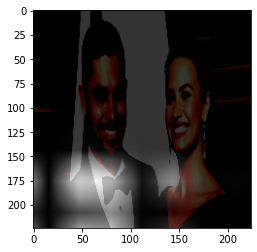

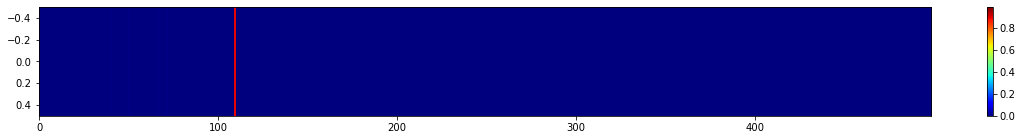

Text Input: with label= tensor(1, device='cuda:1')
[CLS] demi lo ##vat ##o , ex wil ##mer val ##der ##rama reunite for lunch date time for a reunion ! demi lo ##vat ##o and ex - boyfriend wi ##mer val ##der ##rama are spark ##ing reunion rumors after they were spotting dining together at l . a . ’ s sol y luna restaurant . the former couple sport ##ed casual matching hood ##ies for the lunch date on saturday , february 24 , according to t ##m ##z . the website reports that the “ tell me you love me ” cr ##oon ##er , 25 , and the that ’ 70s show al ##um , 38 , were all smiles and laughed as they snack ##ed on gu ##aca ##mo ##le and chips . lo ##vat ##o and val ##der ##rama , who called it quit ##s in june 2016 after six years of dating , fueled reconciliation rumors in august 2017 when the nc ##is star was seen cozy ##ing up to the former disney star at her 25th birthday bash . lo ##vat ##o also shared photos of the two ##some with their arms wrapped around one another in june 2017 duri

In [35]:
for idx, batch in enumerate(val_dataloader):
    ## Preparing input 
    batch = iter(val_dataloader).next()

    img_ip , text_ip, label = batch["image"], batch["BERT_ip"], batch['label']

    b_input_ids, b_attn_mask = tuple(t.to(device) for t in text_ip)
    imgs_ip = img_ip.to(device)
    b_labels = label.to(device)
    
    ## Calculate the attention map
    final_model.eval()
    # Compute logits
    with torch.no_grad():
        logits, att_mask_img, att_mask_text = final_model(text=[b_input_ids, b_attn_mask], image=imgs_ip, label=b_labels)
    
    ## change shape of attention maps images 
    att_mask_img = att_mask_img.view(-1, 7, 7)
    
    for idx in range(len(imgs_ip)):
        
        ## Plot for image 
        plot_img_att_map(img_ip[idx], att_mask_img[idx])
        
        ## Plot for text
        plot_text_att(att_mask_text[idx])
        print("Text Input: with label=", b_labels[idx])
        print(" ".join(tokenizer.convert_ids_to_tokens(text_ip[0][idx].tolist())))
    
    break

In [42]:
import numpy as np

latex_special_token = ["!@#$%^&*()"]

def generate(text_list, attention_list, latex_file, color='red', rescale_value = False):
	assert(len(text_list) == len(attention_list))
	if rescale_value:
		attention_list = rescale(attention_list)
	word_num = len(text_list)
	text_list = clean_word(text_list)
	with open(latex_file,'w') as f:
		f.write(r'''\documentclass[varwidth]{standalone}
\special{papersize=210mm,297mm}
\usepackage{color}
\usepackage{tcolorbox}
\usepackage{CJK}
\usepackage{adjustbox}
\tcbset{width=0.9\textwidth,boxrule=0pt,colback=red,arc=0pt,auto outer arc,left=0pt,right=0pt,boxsep=5pt}
\begin{document}
\begin{CJK*}{UTF8}{gbsn}'''+'\n')
		string = r'''{\setlength{\fboxsep}{0pt}\colorbox{white!0}{\parbox{0.9\textwidth}{'''+"\n"
		for idx in range(word_num):
			string += "\\colorbox{%s!%s}{"%(color, attention_list[idx])+"\\strut " + text_list[idx]+"} "
		string += "\n}}}"
		f.write(string+'\n')
		f.write(r'''\end{CJK*}
\end{document}''')

def rescale(input_list):
	the_array = np.asarray(input_list)*100
# 	the_max = np.max(the_array)
# 	the_min = np.min(the_array)
# 	rescale = (the_array - the_min)/(the_max-the_min)*100
	return rescale.tolist()


def clean_word(word_list):
	new_word_list = []
	for word in word_list:
		for latex_sensitive in ["\\", "%", "&", "^", "#", "_",  "{", "}"]:
			if latex_sensitive in word:
				word = word.replace(latex_sensitive, '\\'+latex_sensitive)
		new_word_list.append(word)
	return new_word_list


In [45]:
words = tokenizer.convert_ids_to_tokens(text_ip[0][0].tolist())
attention = att_mask_text[0].cpu().numpy().tolist()
color = 'red'
generate(words[1:], attention, "sample.tex", color)

In [44]:
len(words), len(attention)

(500, 499)